In [2]:
# !pip install textblob

# !pip install spacy
# !python -m textblob.download_corpora
# !python -m spacy download en_core_web_sm

In [371]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR 

from sklearn.metrics import mean_squared_error
from math import sqrt

In [342]:
import spacy
from textblob import TextBlob
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import stopwords

### 1. Data Processing 

#### Importing Data

##### reading tweets related to stocks: TSLA, AAPL & AMZN

In [4]:
#Read data from Company_Tweet.csv
Company_Tweet_df = pd.read_csv(Path("Resources/Company_Tweet.csv"))
Company_Tweet_df = Company_Tweet_df.set_index('tweet_id')
Company_Tweet_df.sample()

,ticker_symbol
tweet_id,
1105149017795821569,AAPL


In [5]:
#Read data from Tweet.csv
tweet_df = pd.read_csv(Path("Resources/Tweet.csv"))
tweet_df = tweet_df.set_index('tweet_id')
tweet_df.sample()

,writer,post_date,body,comment_num,retweet_num,like_num
tweet_id,,,,,,
1025094469761335296,codywillard,1533236541,Latest episode of http://TheCodyWillardShow.co...,0,0,0


In [6]:
#merge to df into one
Company_tweet_result = tweet_df.merge(Company_Tweet_df, left_index=True, right_index=True)

In [7]:
#select relavent ticker and column.
selected_df = Company_tweet_result[Company_tweet_result['ticker_symbol'].isin(['AAPL', 'TSLA', 'AMZN'])]
selected_df = selected_df[['ticker_symbol', 'post_date','body']]
selected_df.sample()

,ticker_symbol,post_date,body
tweet_id,,,
1147128129334501376,TSLA,1562331633,Don't miss our next FREE OPTION TRADE. Sign u...


In [8]:
# define Start date & end date to use for boolean indexing to filter the rows
start_date = '2019-01-01 00:00:00'
end_date = '2021-12-31 23:59:59'

In [9]:
#convert date into standard format
selected_df['post_date'] = pd.to_datetime(selected_df['post_date'], unit='s')

#filter the data based on post date ranging between start and end date
#rename columns to date, hashtags, text to make the dataframe consistent for concatenation
stock_tweet_df = selected_df[(selected_df['post_date'] >= start_date) & (selected_df['post_date'] <= end_date)]
stock_tweet_df = stock_tweet_df[['ticker_symbol', 'post_date', 'body']]
stock_tweet_df.columns = ['hashtags', 'date', 'text']
stock_tweet_df = stock_tweet_df #.set_index('date')
stock_tweet_df.dropna(inplace = True)
stock_tweet_df.head()

,hashtags,date,text
tweet_id,,,
1079890068867817473,TSLA,2019-01-01 00:00:30,!! 8 Hours Left !!The picture you see here is...
1079890718326431745,TSLA,2019-01-01 00:03:05,$3750 would be the minimum discount in any cas...
1079890782742503424,TSLA,2019-01-01 00:03:20,There are FUDking analysts like those from gol...
1079891097965322240,TSLA,2019-01-01 00:04:35,I really hope they report ‘unbelievable’ numbe...
1079891844807430144,TSLA,2019-01-01 00:07:33,#TESLA : $TSLA Dec-31 Update #StockMarket #Tec...


In [10]:
stock_tweet_df.tail()

,hashtags,date,text
tweet_id,,,
1212159765914079234,AAPL,2019-12-31 23:53:03,That $SPY $SPX puuump in the last hour was the...
1212159838882533376,TSLA,2019-12-31 23:53:21,In 2020 I may start Tweeting out positive news...
1212160015332728833,TSLA,2019-12-31 23:54:03,Patiently Waiting for the no twitter sitter tw...
1212160410692046849,AAPL,2019-12-31 23:55:37,I don't discriminate. I own both $aapl and $ms...
1212160477159206912,AAPL,2019-12-31 23:55:53,"$AAPL #patent 10,522,475 Vertical interconnect..."


##### Reading tweets related to bitcoin

In [11]:
btc_tweet = pd.read_csv(Path("Resources/Bitcoin_tweets.csv"),usecols = ["date", "hashtags", "text"], 
                           #index_col=["date"],
                            parse_dates=["date"])
btc_tweet = btc_tweet[(btc_tweet["date"] <= end_date) |(btc_tweet["date"] >= start_date)]
btc_tweet.head(5)

/var/folders/cn/35r59ch52r57x3jrltx7y1hh0000gn/T/ipykernel_7752/3481373515.py:1: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  btc_tweet = pd.read_csv(Path("Resources/Bitcoin_tweets.csv"),usecols = ["date", "hashtags", "text"],


,date,text,hashtags
0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin']
1,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']"
2,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN
3,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']"
4,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC']


In [12]:
#clean the tweets data by dropping null values and fetching tweets specific to bitcoin  
tags = ['bitcoin','btc','crypto']  
hashtags = '|'.join(tags)
btc_tweet.dropna(inplace = True)
btc_tweet_df = btc_tweet[btc_tweet['hashtags'].str.lower().str.contains(hashtags)]

#replace the hashtags values with 'BTC'
btc_tweet_df['hashtags'] = 'BTC'
btc_tweet_df = btc_tweet_df[['date', 'hashtags', 'text']]
btc_tweet_df.head()

/var/folders/cn/35r59ch52r57x3jrltx7y1hh0000gn/T/ipykernel_7752/3330187670.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_tweet_df['hashtags'] = 'BTC'


,date,hashtags,text
0,2021-02-10 23:59:04,BTC,Blue Ridge Bank shares halted by NYSE after #b...
1,2021-02-10 23:58:48,BTC,"😎 Today, that's this #Thursday, we will do a ""..."
3,2021-02-10 23:54:33,BTC,$BTC A big chance in a billion! Price: \487264...
4,2021-02-10 23:54:06,BTC,This network is secured by 9 508 nodes as of t...
5,2021-02-10 23:53:30,BTC,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...


##### Reading Elon's tweets related for DOGE

In [13]:
# Read data from Emusk_2021_tweets.csv
elon_tweets = pd.read_csv('Resources/Emusk_2021_tweets.csv',
                          infer_datetime_format=True,
                          parse_dates=True,
                         usecols = ['Datetime','Text'])
elon_tweets['hashtags'] = 'DOGE'
elon_tweets.columns = ['date', 'text', 'hashtags']

#convert date column into format of yyyy-mm-dd hh:mm:ss
elon_tweets['date'] = elon_tweets['date']+':00'

#rename columns and display sample
elon_tweets = elon_tweets[['date', 'hashtags', 'text']]#.set_index('date')
elon_tweets.head()

,date,hashtags,text
0,01/01/2021 00:58:00,DOGE,"@PPathole Dojo isn’t needed, but will make sel..."
1,02/01/2021 03:20:00,DOGE,@comma_ai Tesla Full Self-Driving will work at...
2,02/01/2021 12:23:00,DOGE,"@newscientist Um, we have giant fusion reactor..."
3,02/01/2021 14:51:00,DOGE,So proud of the Tesla team for achieving this ...
4,02/01/2021 14:59:00,DOGE,@flcnhvy Tesla is responsible for 2/3 of all t...


In [14]:
#loop for DOGE to resolve issue with datetime and series and convert the column values in required format
#loop to convert the date format to YYYY-MM-DD hh:mm:ss for DOGE
for i in np.arange(len(elon_tweets['date'])):
    elon_tweets['date'][i] = datetime.datetime.strptime(elon_tweets['date'][i],"%d/%m/%Y %H:%M:%S")
    elon_tweets['date'][i].strftime("%Y-%m-%d  %H:%M:%S")

#set index & display df
elon_tweets.head()

,date,hashtags,text
0,2021-01-01 00:58:00,DOGE,"@PPathole Dojo isn’t needed, but will make sel..."
1,2021-01-02 03:20:00,DOGE,@comma_ai Tesla Full Self-Driving will work at...
2,2021-01-02 12:23:00,DOGE,"@newscientist Um, we have giant fusion reactor..."
3,2021-01-02 14:51:00,DOGE,So proud of the Tesla team for achieving this ...
4,2021-01-02 14:59:00,DOGE,@flcnhvy Tesla is responsible for 2/3 of all t...


In [15]:
elon_tweets.tail()

,date,hashtags,text
2988,2021-12-30 18:23:00,DOGE,@BLKMDL3 @mims Predicting macroeconomics is ch...
2989,2021-12-30 20:28:00,DOGE,@CSmithson80 @heydave7 @BLKMDL3 @mims This cha...
2990,2021-12-30 20:47:00,DOGE,@tesla_raj Many UI improvements coming
2991,2021-12-30 21:11:00,DOGE,@roshanpateI 🤣 $7
2992,2021-12-31 02:23:00,DOGE,@TheBabylonBee 🤣


##### Combining tweets datasets for stocks and crypto

In [16]:
#concat dataframes and reset index
combined_df = pd.concat([stock_tweet_df.sample(20000),btc_tweet_df.sample(20000),elon_tweets], axis = 0).reset_index(drop = True)
combined_df.head()

,hashtags,date,text
0,TSLA,2019-06-13 02:43:56,"They won't be ""low income"" for long, once thei..."
1,AAPL,2019-09-20 14:30:04,Is #Bitcoin still in an uptrend? $BTC...
2,AAPL,2019-10-30 19:55:16,Yeah that's why I turned it into a spread. $AA...
3,TSLA,2019-12-27 09:10:03,$TSLA - Tesla confirms $1.29B loan from Chines...
4,TSLA,2019-11-22 15:01:01,$TSLA Chopping around here at a weaker hourly ...


In [17]:
#drop duplucates and display data
combined_df.drop_duplicates( keep = 'first', inplace = True)
combined_df.count()

hashtags    42993
date        42993
text        42993
dtype: int64

In [18]:
#Safety function to convert date format to YYYY-MM-DD hh:mm:ss
def date_format(df_col):
    for i in np.arange(len(df_col)):
        
        res = True
        try:
            res = bool(datetime.datetime.strptime(df_col[i], "%Y-%m-%d %H:%M:%S"))
        except ValueError:
            res = False    
        if(not(res)):
            df_col[i] = datetime.datetime.strptime(df_col[i],"%m/%d/%Y %H:%M:%S")
            df_col[i].strftime("%Y-%m-%d %H:%M:%S")
    return df_col

In [19]:
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['date'] = combined_df['date'].dt.date
 #= date_format(combined_df['date'].astype(str))

In [20]:
#drop duplicate records and count values pre and post removing duplicates
display(combined_df.count())
combined_df.drop_duplicates( keep = 'first', inplace = True)
combined_df.count()

hashtags    42993
date        42993
text        42993
dtype: int64

hashtags    42866
date        42866
text        42866
dtype: int64

In [21]:
combined_df.head()

,hashtags,date,text
0,TSLA,2019-06-13,"They won't be ""low income"" for long, once thei..."
1,AAPL,2019-09-20,Is #Bitcoin still in an uptrend? $BTC...
2,AAPL,2019-10-30,Yeah that's why I turned it into a spread. $AA...
3,TSLA,2019-12-27,$TSLA - Tesla confirms $1.29B loan from Chines...
4,TSLA,2019-11-22,$TSLA Chopping around here at a weaker hourly ...


##### Reading price data for each stock and crypto

In [77]:
#import tsla stock price and filter the date
tsla_csv = Path("Resources/TSLA.csv")
tsla_df = pd.read_csv(tsla_csv, index_col="Date", parse_dates=True)
tsla_df.sort_index()
tsla_df['Ticker'] = 'TSLA'
tsla_df['Returns'] = tsla_df['Close'].pct_change()
tsla_df = tsla_df[['Ticker', 'Close', 'Returns']]
tsla_df.index = pd.to_datetime(tsla_df.index)
start_date = '2019-01-01 00:00:00'
end_date = '2022-12-31 23:59:59'
tsla_df = tsla_df[(tsla_df.index >= start_date) & (tsla_df.index <= end_date)]

tsla_df.head()

,Ticker,Close,Returns
Date,,,
2019-01-02,TSLA,20.674667,NaN
2019-01-03,TSLA,20.024000,-0.031472
2019-01-04,TSLA,21.179333,0.057697
2019-01-07,TSLA,22.330667,0.054361
2019-01-08,TSLA,22.356667,0.001164


In [82]:
#import amzn stock price and filter the date
amzn_csv = Path("Resources/AMZN.csv")
amzn_df = pd.read_csv(amzn_csv, index_col="Date", parse_dates=True)
amzn_df.sort_index()
amzn_df['Ticker'] = 'AMZN'
amzn_df['Returns'] = amzn_df['Close'].pct_change()
amzn_df = amzn_df[['Ticker', 'Close','Returns' ]]
amzn_df.index = pd.to_datetime(amzn_df.index)
start_date = '2019-01-01 00:00:00'
end_date = '2020-01-31 23:59:59'
amzn_df = amzn_df[(amzn_df.index >= start_date) & (amzn_df.index <= end_date)]
amzn_df.head()

,Ticker,Close,Returns
Date,,,
2019-01-02,AMZN,76.956497,NaN
2019-01-03,AMZN,75.014000,-0.025241
2019-01-04,AMZN,78.769501,0.050064
2019-01-07,AMZN,81.475502,0.034353
2019-01-08,AMZN,82.829002,0.016612


In [111]:
#import aapl stock price and filter the date
aapl_csv = Path("Resources/AAPL.csv")
aapl_df = pd.read_csv(aapl_csv, parse_dates=True)
aapl_df.index = pd.to_datetime(aapl_df['Date'], format = "%d-%m-%Y")
aapl_df['Ticker'] = 'AAPL'
aapl_df['Returns'] = aapl_df['Close'].pct_change()
aapl_df = aapl_df[['Ticker', 'Close', 'Returns']]
start_date = '2019-01-01 00:00:00'
end_date = '2020-01-31 23:59:59'
aapl_df = aapl_df[(aapl_df.index >= start_date) & (aapl_df.index <= end_date)]
aapl_df.head()

,Ticker,Close,Returns
Date,,,
2019-01-02,AAPL,39.480000,0.001141
2019-01-03,AAPL,35.547501,-0.099607
2019-01-04,AAPL,37.064999,0.042689
2019-01-07,AAPL,36.982498,-0.002226
2019-01-08,AAPL,37.687500,0.019063


In [127]:
# Import bitcoin prices csv
btc_prices = pd.read_csv('Resources/BTC-USD.csv', 
    infer_datetime_format=True, 
    index_col="Date" ,                     
    parse_dates=True)
start_date = '2021-01-01 00:00:00'
end_date = '2022-12-31 23:59:59'
btc_prices = btc_prices[(btc_prices.index >= start_date) & (btc_prices.index <= end_date)]
btc_prices['Ticker'] = 'BTC'
btc_prices['Returns'] = btc_prices['Close'].pct_change()
btc_prices = btc_prices[['Ticker','Close','Returns']]
# display dataframe
btc_prices.head()

,Ticker,Close,Returns
Date,,,
2021-01-01,BTC,29374.152344,NaN
2021-01-02,BTC,32127.267578,0.093726
2021-01-03,BTC,32782.023438,0.020380
2021-01-04,BTC,31971.914063,-0.024712
2021-01-05,BTC,33992.429688,0.063197


In [121]:
# Import doge prices csv
doge_prices = pd.read_csv('Resources/dogecoin_prices_2021.csv', 
    infer_datetime_format=True, 
    parse_dates=True)

# display dataframe
doge_prices.head()

,open_time,price
0,01/01/2021 00:00,0.004672
1,01/01/2021 00:01,0.004673
2,01/01/2021 00:02,0.004686
3,01/01/2021 00:03,0.004671
4,01/01/2021 00:04,0.004676


In [ ]:
# Import doge prices csv
doge_prices = pd.read_csv('Resources/dogecoin_prices_2021.csv', 
    infer_datetime_format=True, 
    parse_dates=True)

# display dataframe
doge_prices.head()

In [ ]:
#fetching closing prices for Doge
doge_prices = doge_prices[doge_prices['open_time'].str.contains('23:59')]
doge_prices.columns = ['date', 'price']

# display dataframe
doge_prices.head()

In [122]:
#fetching closing prices for Doge
doge_prices['open_time'] = doge_prices['open_time'].astype(str)
doge_prices = doge_prices[doge_prices['open_time'].str.contains('23:59')]
doge_prices.head()

,open_time,price
1439,01/01/2021 23:59,0.005665
2879,02/01/2021 23:59,0.010580
4319,03/01/2021 23:59,0.009810
5759,04/01/2021 23:59,0.009771
7199,05/01/2021 23:59,0.009994


In [123]:
#convert date column into format of yyyy-mm-dd hh:mm:ss
#doge_prices['open_time'] = doge_prices['open_time']+':00'
doge_prices['open_time'] = pd.to_datetime(doge_prices['open_time'],format = "%d/%m/%Y %H:%M")
doge_prices = doge_prices[(doge_prices['open_time'] >= start_date) & (doge_prices['open_time'] <= end_date)]
doge_prices['open_time'] = doge_prices['open_time'].dt.date
doge_prices['Ticker'] = 'DOGE'
doge_prices['Returns'] = doge_prices['price'].pct_change()
doge_prices = doge_prices[['open_time','Ticker','price', 'Returns']]
doge_prices.columns = ['Date','Ticker', 'Close', 'Returns']

#set index 
doge_prices = doge_prices.set_index('Date')

#display dataframe
doge_prices.head()


,Ticker,Close,Returns
Date,,,
2021-01-01,DOGE,0.005665,NaN
2021-01-02,DOGE,0.010580,0.867828
2021-01-03,DOGE,0.009810,-0.072813
2021-01-04,DOGE,0.009771,-0.004026
2021-01-05,DOGE,0.009994,0.022916


In [259]:
#create copy of price datasets & concat in one Prices_df dataframe
tsla = tsla_df.copy().reset_index()
amzn = amzn_df.copy().reset_index()
aapl = aapl_df.copy().reset_index()
doge = doge_prices.copy().reset_index()
btc = btc_prices.copy().reset_index()

prices_df = pd.concat([tsla,amzn,aapl,btc,doge], axis = 0)
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
prices_df = prices_df[['Date','Ticker','Close']]
prices_df.columns = ['date','ticker','close']

prices_df.head()

,date,ticker,close
0,2019-01-02,TSLA,20.674667
1,2019-01-03,TSLA,20.024000
2,2019-01-04,TSLA,21.179333
3,2019-01-07,TSLA,22.330667
4,2019-01-08,TSLA,22.356667


#### 2.Data cleaning 

##### cleaning tweets for sentiment analysis

In [25]:
df_sentiment=combined_df.copy()

In [26]:
# Load the English language model
nlp = spacy.load("en_core_web_sm")

def preprocess(sentence, stemming=False, lemmatizing=False):
    # global counter
    # counter += 1
    # if counter % 100 == 0:
    #     pass
    #     # print(counter)

    sentence = str(sentence)
    #get rid of non-ascii characters
    tokenizer = RegexpTokenizer(r'\w+')

    sentence = sentence.lower()
    #get rid of links & special characters characters
    sentence = sentence.replace('{html}', "")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '', cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokens = tokenizer.tokenize(rem_num)

    filtered_words = [w for w in tokens if w not in stopwords.words('english')]

    if lemmatizing:
        doc = nlp(" ".join(filtered_words))
        lemma_words = [token.lemma_ for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
        return " ".join(lemma_words)

    if stemming:
        stemmer = PorterStemmer()
        stem_words = [stemmer.stem(w) for w in filtered_words]
        return " ".join(stem_words)

    return " ".join(filtered_words)



,hashtags,date,text,tokenized_text
0,TSLA,2019-06-13,"They won't be ""low income"" for long, once thei...",low income long tesla start go night whore tsl...
1,AAPL,2019-09-20,Is #Bitcoin still in an uptrend? $BTC...,bitcoin uptrend btc eth xrp ltc cryptocurrenci...
2,AAPL,2019-10-30,Yeah that's why I turned it into a spread. $AA...,yeah turn spread aapl main large spy bullish p...
3,TSLA,2019-12-27,$TSLA - Tesla confirms $1.29B loan from Chines...,tsla tesla confirm b loan chinese bank shangha...
4,TSLA,2019-11-22,$TSLA Chopping around here at a weaker hourly ...,tsla chop weak hourly hourly zone sense play c...


In [ ]:
#call preprocess function to clean the tweets dataset
df_sentiment['tokenized_text'] = df_sentiment['text'].apply(lambda x: preprocess(x, stemming=False, lemmatizing=True))
df_sentiment.head()

In [163]:
#df_sentiment.drop_duplicates(subset=['tokenized_text','hashtags'], keep = 'first', inplace = True)

#### 3. Sentiment Analysis usin Textblob

In [28]:
#generatin sentiment & polarity using TextBlob
nlp = spacy.load('en_core_web_sm')

def analyze_sentiment(text):
    doc = nlp(text)
    blob = TextBlob(text)
    
    polarity = blob.sentiment.polarity
    
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment, polarity

# Assuming df is your DataFrame with 'text' column
df_sentiment['sentiment'], df_sentiment['polarity'] = zip(*df_sentiment['tokenized_text'].apply(analyze_sentiment))

df_sentiment = df_sentiment.sort_values('polarity').reset_index(drop=True)
df_sentiment.sample()


,hashtags,date,text,tokenized_text,sentiment,polarity
7119,BTC,2022-04-21,#bitcoin SCAM alert again @Shibtoken funds to...,bitcoin scam alert shibtoken fund tron shamele...,neutral,0.0


In [182]:
#check the counts for each sentiment type
df_sentiment["sentiment"].value_counts()

neutral     17173
positive    16093
negative     6071
Name: sentiment, dtype: int64

% of positive tweets=  40.91059308030607
% of negative tweets=  15.433307064595672
% of neutral tweets=  43.656099855098255


[]

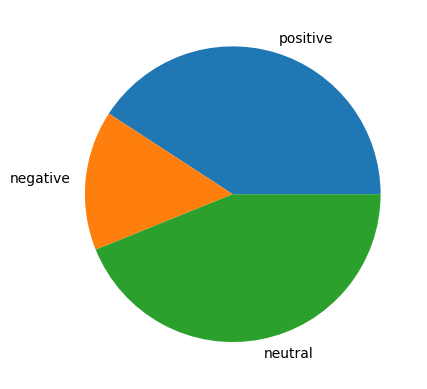

In [263]:
#create pie chart to understand overall distribution of sentiments
positive=(df_sentiment["sentiment"].value_counts()['positive']/(len(df_sentiment)))*100
negative=(df_sentiment["sentiment"].value_counts()['negative']/(len(df_sentiment)))*100
neutral=(df_sentiment["sentiment"].value_counts()['neutral']/(len(df_sentiment)))*100

#display %age of tweets in each sentiment category
print("% of positive tweets= ",positive)
print("% of negative tweets= ",negative)
print("% of neutral tweets= ",neutral)
    
arr=np.asarray([positive,negative,neutral], dtype=int)
plt.figure()
plt.pie(arr,labels=['positive','negative', 'neutral'])
plt.plot()


In [159]:
# Check & extract the most common words found in both positive and negative positive reviews
df_neg = df_sentiment[df_sentiment['polarity'] < 0]
df_pos = df_sentiment[df_sentiment['polarity'] > 0]
df_neutral = df_sentiment[df_sentiment['polarity'] == 0]

In [161]:
# display tweets in each sentiment category of positive, Negative & Nutral
print("Negative reviews")
display(df_neg.head(3))
print("Positive reiews")
display(df_pos.head(3))
print("Neutral reiews")
display(df_neutral.head(3))

Negative reviews


,hashtags,date,text,tokenized_text,sentiment,polarity
0,AAPL,2019-01-09,TD Ameritrade's Investor Movement Index Highli...,td ameritrade investor movement index highligh...,negative,-1.0
1,BTC,2021-07-28,@CryptomutantX @BabyCakeBSC @Bitcoin @ethereum...,cryptomutantx babycakebsc bitcoin ethereum dog...,negative,-1.0
2,TSLA,2019-04-04,"Grim humor, or what?$tsla $tslaq",grim humor tsla tslaq,negative,-1.0


Positive reiews


,hashtags,date,text,tokenized_text,sentiment,polarity
23244,TSLA,2019-05-21,"Tesla $TSLA saw an intra low of $195.25, settl...",tesla tsla see intra low settle daily candle h...,positive,2.312965e-18
23245,TSLA,2019-10-25,"If tesla continues to rally into the close, it...",tesla continue rally close clear institution s...,positive,2.775558e-18
23246,DOGE,2021-10-27,"@wapodavenport US national debt is ~$28,900 bi...",wapodavenport national debt billion k taxpayer...,positive,4.625929e-18


Neutral reiews


,hashtags,date,text,tokenized_text,sentiment,polarity
6071,BTC,2022-05-13,Do we see #bitcoin back to 3k in next 2 weeks ???,bitcoin k week,neutral,0.0
6072,BTC,2021-11-26,@BITCOINTRAPPER 🚨 @NanoINDC 🚨\n\nThe CookieTok...,bitcointrapper nanoindc cookietokenindc launch...,neutral,0.0
6073,DOGE,2021-01-25,@TeslaGong @teslaownersSV @cleantechnica I hop...,teslagong teslaownerssv cleantechnica hope,neutral,0.0


In [162]:
#fetching the common words in positive and negative tweets
from collections import Counter

# Extracting the most common words found in both positive and negative positive reviews:
positive_words = pd.DataFrame([dict(Counter(' '.join(df_pos['tokenized_text'].values.tolist()).split(' ')))]).T.sort_values(0, ascending=False)[0:100].index

negative_words = pd.DataFrame([dict(Counter(' '.join(df_neg['tokenized_text'].values.tolist()).split(' ')))]).T.sort_values(0, ascending=False)[0:100].index

In [35]:
display("Most common words in POSITIVE tweets:",positive_words)
display("Most common words in NEGATIVE tweets:",negative_words)

'Most common words in POSITIVE tweets on ETH:'

Index(['bitcoin', 'btc', 'tsla', 'crypto', 'aapl', 'project', 'good', 'amzn',
       'eth', 'cryptocurrency', 'new', 'tesla', 'great', 'airdrop', 'stock',
       'high', 'bsc', 'market', 'buy', 'free', 'nft', 'bnb', 'time', 'fb',
       'like', 'amp', 'price', 'tslaq', 'day', 'k', 'spy', 'nflx', 'binance',
       'trading', 'trade', 'go', 'ethereum', 'blockchain', 'look', 'today',
       'join', 'future', 'team', 'right', 'defi', 'money', 'think', 'year',
       'week', 'follow', 'strong', 'short', 'come', 'long', 'googl', 'sell',
       'nvda', 'car', 'live', 'big', 'qqq', 'real', 'know', 'people',
       'company', 'thank', 'need', 'apple', 'amd', 'low', 'love', 'option',
       'news', 'work', 'amazing', 'elonmusk', 'nice', 'altcoin', 'model',
       'invest', 'support', 'start', 'well', 'say', 'tweet', 'baba', 'win',
       'x', 'world', 'find', 'sure', 'let', 'share', 'play', 'huge', 'want',
       'msft', 'doge', 'way', 'spx'],
      dtype='object')

'Most common words in NEGATIVE tweets on ETH:'

Index(['tsla', 'bitcoin', 'btc', 'aapl', 'amzn', 'long', 'tesla', 'crypto',
       'tslaq', 'market', 'stock', 'buy', 'eth', 'k', 'fb', 'time', 'price',
       'like', 'nflx', 'short', 'game', 'go', 'spy', 'day', 'bad', 'year',
       'nft', 'base', 'trade', 'money', 'cryptocurrency', 'today', 'look',
       'amp', 'mean', 'late', 'think', 'news', 'sell', 'week', 'new', 'come',
       'car', 'qqq', 'know', 'elon', 'people', 'company', 'amd', 'binance',
       'hard', 'ethereum', 'apple', 'nvda', 'model', 'need', 'musk',
       'blockchain', 'msft', 'sale', 'get', 'big', 'trading', 'hold', 'sec',
       'say', 'term', 'low', 'invest', 'elonmusk', 'small', 'close', 'twtr',
       'way', 'bnb', 'little', 'spx', 'past', 'green', 'month', 'stop', 'q',
       'work', 'start', 'high', 'wrong', 'x', 'want', 'intc', 'fail',
       'average', 'profit', 'follow', 'bsc', 'break', 'thing', 'ba', 'well',
       'gold', 'investor'],
      dtype='object')

In [164]:
#splitting the sentiments for stocks and cryptos in seperate df for Vizualisation
df_sentiment_stocks = df_sentiment[(df_sentiment['hashtags'] == 'AAPL')| 
                                   (df_sentiment['hashtags'] == 'AMZN') |
                                   (df_sentiment['hashtags'] == 'TSLA')]
df_sentiment_crypto = df_sentiment[(df_sentiment['hashtags'] == 'BTC')| 
                                   (df_sentiment['hashtags'] == 'DOGE')]
display(df_sentiment_stocks.head())
display(df_sentiment_crypto.head())

,hashtags,date,text,tokenized_text,sentiment,polarity
0,AAPL,2019-01-09,TD Ameritrade's Investor Movement Index Highli...,td ameritrade investor movement index highligh...,negative,-1.0
2,TSLA,2019-04-04,"Grim humor, or what?$tsla $tslaq",grim humor tsla tslaq,negative,-1.0
3,AAPL,2019-02-21,$SPX $QQQ $SPY $XLY $XLK $AAPL $GOOGL $TSLA ju...,spx qqq spy xly xlk aapl googl tsla awful,negative,-1.0
5,TSLA,2019-07-28,via barronsonline: Tesla Stock Is Having a Ter...,barronsonline tesla stock terrible year earnin...,negative,-1.0
7,TSLA,2019-09-08,"$TSLA is all about ""outrageous claim[s]"". $TSLAQ",tsla outrageous claim tslaq,negative,-1.0


,hashtags,date,text,tokenized_text,sentiment,polarity
1,BTC,2021-07-28,@CryptomutantX @BabyCakeBSC @Bitcoin @ethereum...,cryptomutantx babycakebsc bitcoin ethereum dog...,negative,-1.0
4,BTC,2022-06-29,#bitcoin under $20K again. \n\nboring.,bitcoin k boring,negative,-1.0
6,BTC,2021-08-05,#Eth is killing it! Insane Altseason incoming ...,eth kill insane altseason incoming floki orn e...,negative,-1.0
8,BTC,2022-05-28,@Altcoinbuzzio @IOHK_Charles I hold mostly #BT...,altcoinbuzzio iohk_charle hold btc feel disgus...,negative,-1.0
12,DOGE,2021-11-29,@ZainS180 @VikingRocket @WholeMarsBlog Cybertr...,zain vikingrocket wholemarsblog cybertruck int...,negative,-1.0


In [257]:
#Calculating the avg polarity for each stock/crypto for each day and sentiment
daily_polarity_mean = df_sentiment.groupby(['date','hashtags'])['polarity'].mean()

In [258]:
daily_polarity_mean = pd.DataFrame(daily_polarity_mean)
daily_polarity_mean.reset_index(inplace = True)
daily_polarity_mean['date'] = pd.to_datetime(daily_polarity_mean['date']).dt.date
daily_polarity_mean.head()

,date,hashtags,polarity
0,2019-01-01,AAPL,0.201488
1,2019-01-01,AMZN,0.075000
2,2019-01-01,TSLA,0.005022
3,2019-01-02,AAPL,0.009988
4,2019-01-02,AMZN,0.131954


##### Vizualisation functions 

In [146]:
#define function to plot no. positive/negative tweets over time

def func_polarity(df):
    # Convert the 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Group the data by date and sentiment, then count the number of tweets
    sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

    # Resample the data by day and fill any missing dates
    sentiment_counts = sentiment_counts.resample('D').sum()

    # Create a line chart
    plt.figure(figsize=(12, 6))
    plt.plot(sentiment_counts.index, sentiment_counts['positive'], label='Positive', marker='o')
    plt.plot(sentiment_counts.index, sentiment_counts['negative'], label='Negative', marker='o')
    plt.plot(sentiment_counts.index, sentiment_counts['neutral'], label='Neutral', marker='o')
    
    plt.xlabel('Date')
    plt.ylabel('Number of Tweets')
    plt.title('Analysis Over Time')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [173]:
#define function to vizualise the change in Daily returns and tweet sentiments

def viz_func(price_df):
#filter data for DOGE
    sentiment_plot = daily_polarity_mean[daily_polarity_mean['hashtags'] == price_df['Ticker'][0]]
    # Resample the data by day and fill any missing dates
    #sentiment_counts = sentiment_counts.resample('D').sum()

    # Create a line chart
    plt.figure(figsize=(12, 6))
    plt.plot(sentiment_plot['date'], sentiment_plot['polarity'], label='polarity', marker='o')
    plt.plot(price_df.index, price_df['Returns'], label='price', marker='o')
    #plt.plot(sentiment_counts.index, sentiment_counts['neutral'], label='Neutral', marker='o')

    plt.xlabel('Date: YYYY-MM')
    plt.ylabel('Sentiments/Price')
    plt.title('Analysis Over Time')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

Stocks:


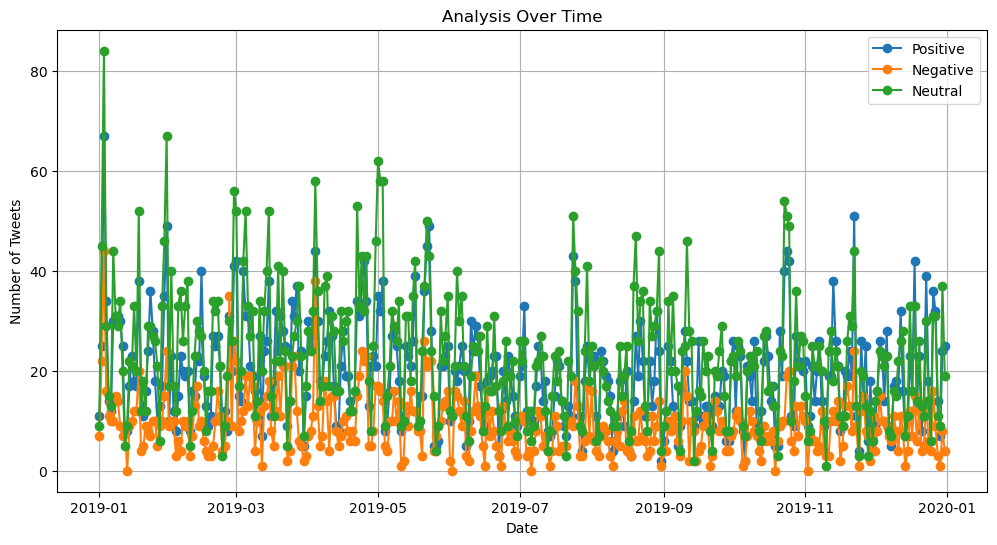

Crypto:


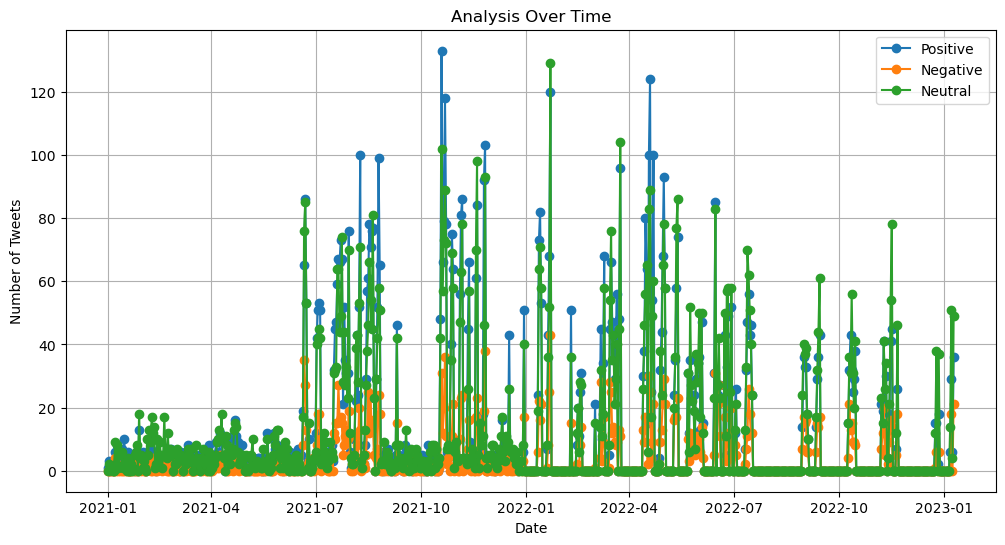

In [170]:
#vizualize number of tweets for each polarity type for stocks and crypto
print("Stocks:")
func_polarity(df_sentiment_stocks)
print("Crypto:")
func_polarity(df_sentiment_crypto)

Sentimen/Price plot for Amazon


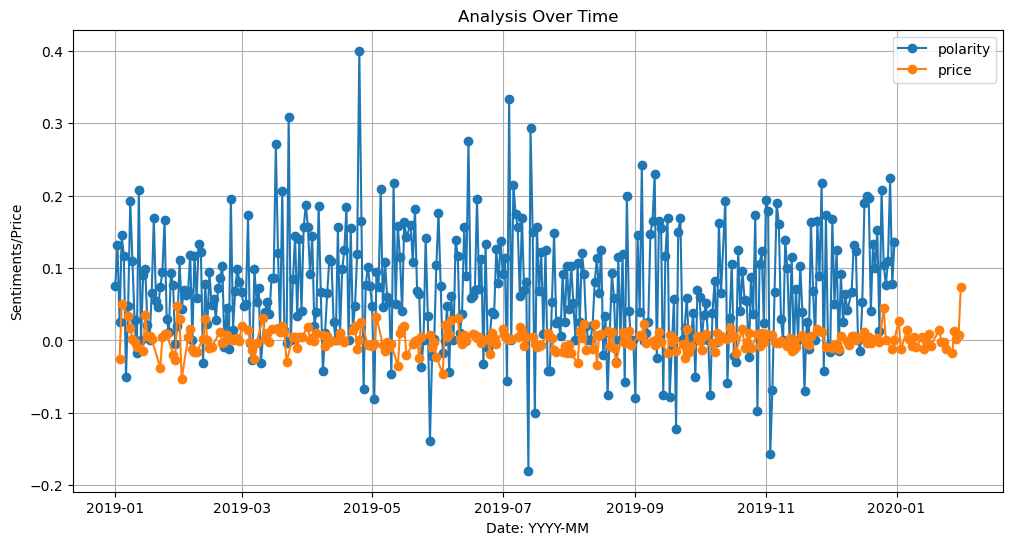

Sentimen/Price plot for TSLA


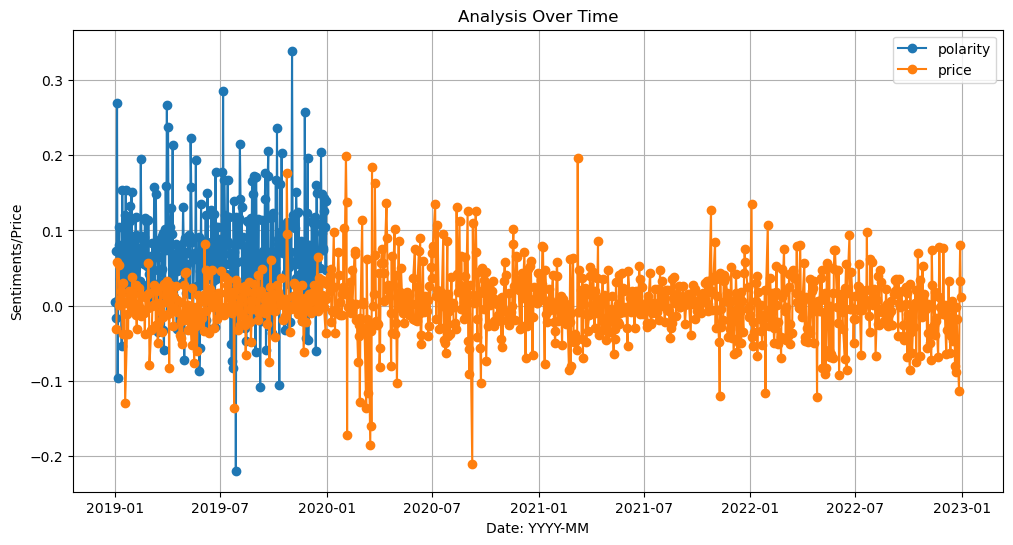

Sentimen/Price plot for AAPL


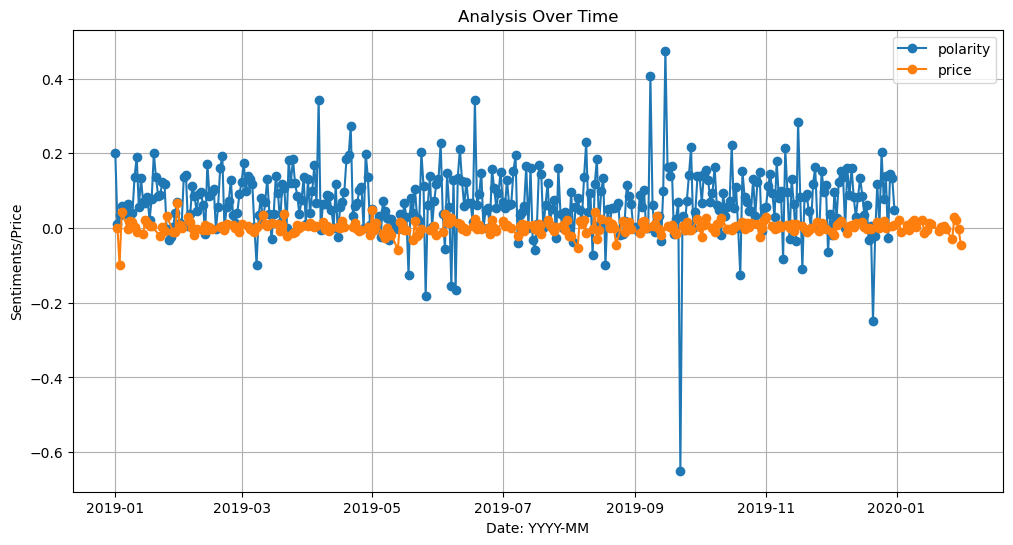

Sentimen/Price plot for BTC


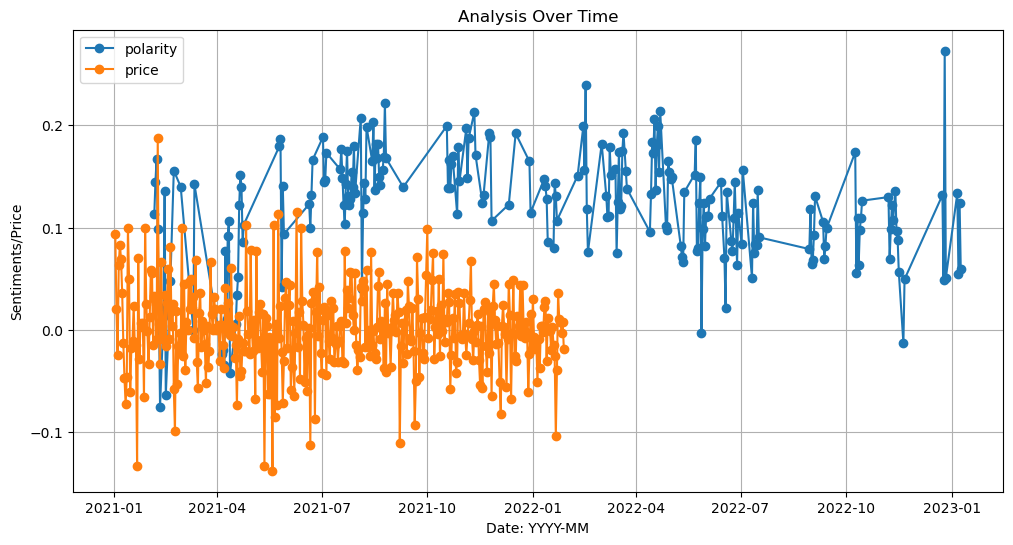

Sentimen/Price plot for DOGE


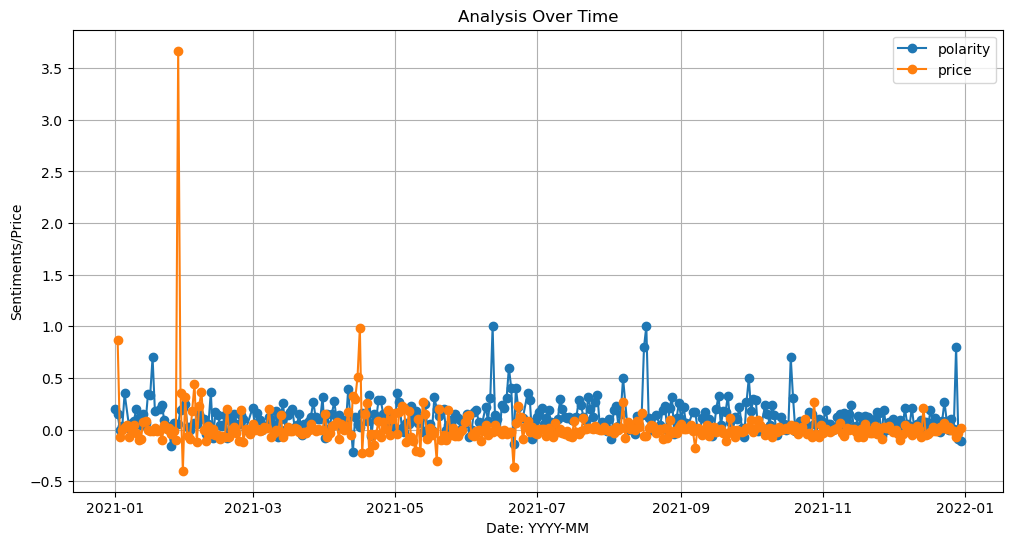

In [174]:
print("Sentimen/Price plot for Amazon")
viz_func(amzn_df)
print("Sentimen/Price plot for TSLA")
viz_func(tsla_df)
print("Sentimen/Price plot for AAPL")
viz_func(aapl_df)
print("Sentimen/Price plot for BTC")
viz_func(btc_prices)
print("Sentimen/Price plot for DOGE")
viz_func(doge_prices)


From our analysis using twitter sentiments(positive/negative) no observable impact on stock price is identified by change in twitter sentiments. **However**, in next section we've tried to train our models on tweets tweeted each day and price for that day in order to 

### 4. Price prediction

#### In this section we'll predict the price for stock/crypto using RF & SVR algoriths

we'll train our model on the dataset containg no. of tweets tweeted each day for each positive/negative/neutral category and price for that day and then test our models to see if tweets actually have any influence of stock prices.

In [329]:
'''create dataframe that contains no. of tweets per day for each sentiment 
category(Positive/Negative/Neutral)'''

count_sentiments_df = pd.DataFrame()
sentiment_counts = df_sentiment.groupby(['date', 'sentiment']).size().unstack(fill_value=0)
sentiment_counts.reset_index(inplace = True)
count_sentiments_df['date'] = pd.to_datetime(sentiment_counts['date']).dt.date
count_sentiments_df['negative'] = sentiment_counts['negative']
count_sentiments_df['positive'] = sentiment_counts['positive']
count_sentiments_df['neutral'] = sentiment_counts['neutral']
count_sentiments_df

,date,negative,positive,neutral
0,2019-01-01,7,11,9
1,2019-01-02,22,25,45
2,2019-01-03,44,67,84
3,2019-01-04,16,34,29
4,2019-01-05,11,14,15
...,...,...,...,...
832,2022-12-27,6,18,37
833,2023-01-06,0,6,14
834,2023-01-07,18,29,51
835,2023-01-08,0,6,4


In [384]:
#Using Random Forest regressor to predict prices for our stock/crypto based on tweet each day
def randomforestModel(df):
    df.reset_index(inplace= True)
    train, test = train_test_split(df, shuffle=False, test_size=0.2)

    sentiment_list_train = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'negative'],  df.loc[date, 'neutral'], df.loc[date, 'positive']])
        sentiment_list_train.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_list_train)

    sentiment_list_test = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'negative'],  df.loc[date, 'neutral'], df.loc[date, 'positive']])
        sentiment_list_test.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_list_test)
    
    y_train = pd.DataFrame(train['close'])
    y_test = pd.DataFrame(test['close'])
    
    rf = RandomForestRegressor()
    rf.fit(numpy_df_train, y_train)
    prediction = rf.predict(numpy_df_test)

    print("\n\n")
    plt.figure()
    plt.plot(test['close'].iloc[:].values)
    plt.plot(prediction.flatten())
    plt.title('Random Forest predicted prices')
    plt.ylabel('Stock Prices')
    plt.xlabel('Days')
    plt.legend(['actual', 'predicted'])
    plt.show()

    print("\n\n")
    print("RMSE value for Random Forest Model : ")
    rmse = sqrt(mean_squared_error(y_test, prediction.flatten()))
    print(rmse)
    print("\n\n")

In [392]:
#using support vector regression model to predict prices for our stock/crypto based on tweet each day
def SVRModel(df):
    df.reset_index(inplace= True)
    train, test = train_test_split(df, shuffle=False, test_size=0.2)

    sentiment_list_train = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'negative'],  df.loc[date, 'neutral'], df.loc[date, 'positive']])
        sentiment_list_train.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_list_train)

    sentiment_list_test = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'negative'],  df.loc[date, 'neutral'], df.loc[date, 'positive']])
        sentiment_list_test.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_list_test)

    y_train = pd.DataFrame(train['close'])
    y_test = pd.DataFrame(test['close'])

    svr_rbf = SVR(kernel='rbf', C=1e6, gamma=0.1)
    svr_rbf.fit(numpy_df_train, y_train.values.flatten())
    output_test_svm = svr_rbf.predict(numpy_df_test)

    plt.figure()
    plt.plot(test['close'].iloc[:].values)
    plt.plot(output_test_svm)
    plt.title('SVM predicted prices')
    plt.ylabel('Stock Prices')
    plt.xlabel('Days')
    plt.legend(['actual', 'predicted'])
    plt.show()

    print("\n\n")
    print("RMSE value for Support Vector Regression Model : ")
    rmse = sqrt(mean_squared_error(y_test, output_test_svm))
    print(rmse)
    print("\n\n")

In [397]:
#define function to call RF & SVR price prediction models
def func_df(hashtag):
    #create df containing date,polarity & price to predict the price
    df_prices = prices_df[['date','close']][prices_df['ticker'] == hashtag].set_index('date')
    df = pd.concat([count_sentiments_df.set_index('date'),df_prices] , axis = 1, join = 'inner')
    randomforestModel(df)
    SVRModel(df)
    

Enter a valid ticker/hashtag:  AMZN


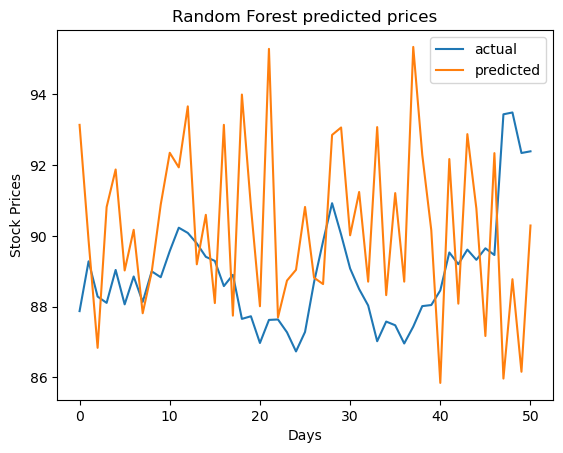




RMSE value for Random Forest Model : 
3.3030093687383992





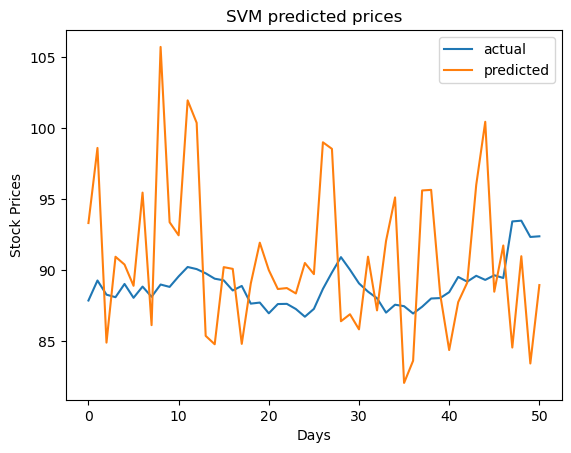




RMSE value for Support Vector Regression Model : 
5.765452487800491





In [396]:
#enter stock/crypto name to check the price prediction 

ticker = input("Enter a valid ticker/hashtag: ") 
if(ticker in daily_polarity_mean['hashtags'].unique()):
    hashtag  = ticker
    func_df(hashtag)
else:
    hashtag = "AAPL"
    func_df(hashtag)
    
   